In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stocks/GOOGL.csv
/kaggle/input/stocks/ABBV.csv
/kaggle/input/stocks/TSLA.csv
/kaggle/input/stocks/MSFT.csv
/kaggle/input/stocks/PLD.csv
/kaggle/input/stocks/BA.csv
/kaggle/input/stocks/AAPL.csv
/kaggle/input/stocks/XOM.csv
/kaggle/input/stocks/BLK.csv
/kaggle/input/stocks/PFE.csv
/kaggle/input/stocks/COP.csv
/kaggle/input/stocks/MRK.csv
/kaggle/input/stocks/NVDA.csv
/kaggle/input/stocks/SBUX.csv
/kaggle/input/stocks/AMZN.csv
/kaggle/input/stocks/ADBE.csv
/kaggle/input/stocks/BAC.csv
/kaggle/input/stocks/LIN.csv
/kaggle/input/stocks/JNJ.csv
/kaggle/input/stocks/AMD.csv
/kaggle/input/stocks/CRM.csv
/kaggle/input/stocks/FCX.csv
/kaggle/input/stocks/HON.csv
/kaggle/input/stocks/CVX.csv
/kaggle/input/stocks/CAT.csv
/kaggle/input/stocks/JPM.csv
/kaggle/input/stocks/NEE.csv
/kaggle/input/stocks/META.csv
/kaggle/input/stocks/GS.csv
/kaggle/input/stocks/DUK.csv
/kaggle/input/stocks/SPY.csv
/kaggle/input/stocks/HD.csv
/kaggle/input/stocks/AMT.csv


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting, BlackLittermanModel
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientCVaR, EfficientSemivariance


In [44]:
# Portfolio Optimization – Summary

# Goal:
# Construct an optimal, diversified portfolio that maximizes risk-adjusted returns.

# Return & Risk Estimation:
# - Expected returns calculated using mean historical log returns.
# - Covariance matrix estimated using Ledoit-Wolf shrinkage for stability.

# Optimization Techniques:
# - Sharpe ratio maximization using Efficient Frontier with L2 regularization.
# - Risk-based optimization: CVaR and semivariance frontiers for downside-focused strategies.
# - Discrete allocation computed for real-world investability with a $10,000 budget.

# Advanced Enhancements:
# - Rolling optimization simulates how the optimal portfolio evolves over time.
# - Market stress test quantifies value impact under hypothetical 20% shocks.
# - Black-Litterman model blends investor views with market equilibrium for customized allocation.

# Visualizations:
# - Efficient Frontier with optimal portfolio point.
# - Heatmaps showing weight distributions across strategies.
# - Rolling expected returns chart for backtesting insight.

# Why It’s Useful:
# This approach offers a practical and robust framework for building optimized portfolios using modern portfolio theory, downside risk measures, and Bayesian-informed customization.

In [9]:
data_dir = "/kaggle/input/stocks/"
close_data = {}

In [10]:
for file in os.listdir(data_dir):
    if file.endswith(".csv") and file.upper() != "SPY.CSV":
        ticker = file.replace(".csv", "")
        path = os.path.join(data_dir, file)
        try:
            df = pd.read_csv(path, usecols=["Date", "Close"])
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df.set_index("Date", inplace=True)
            df = df[["Close"]].rename(columns={"Close": ticker})
            close_data[ticker] = df
        except Exception as e:
            print(f"⚠️ Skipped {ticker}: {e}")



In [11]:
price_df = pd.concat(close_data.values(), axis=1)
price_df.dropna(inplace=True)
price_df.head(1)


,GOOGL,ABBV,TSLA,MSFT,PLD,BA,AAPL,XOM,BLK,PFE,...,HON,CVX,CAT,JPM,NEE,META,GS,DUK,HD,AMT
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-16,56.449364,69.54631,18.439333,103.964432,54.155453,356.182556,52.803131,59.657154,346.788879,31.670357,...,135.154526,88.555916,123.973625,90.689362,36.640392,158.175766,190.48082,62.046329,166.06308,124.874329


In [28]:
# ========== Expected Returns and Covariance ==========
mu = expected_returns.mean_historical_return(price_df)
S = risk_models.CovarianceShrinkage(price_df).ledoit_wolf()

In [18]:
# ========== Efficient Frontier: Max Sharpe Ratio ==========
ef = EfficientFrontier(mu, S)
ef.add_objective(lambda w: w @ w)  # L2 regularization for diversification
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

In [29]:
# ========== Portfolio Performance ==========
expected_return, volatility, sharpe = ef.portfolio_performance(verbose=True)

Expected annual return: 35.1%
Annual volatility: 26.7%
Sharpe Ratio: 1.31


In [30]:
# Display allocation
print("\nOptimized Portfolio Allocation:")
for asset, weight in cleaned_weights.items():
    if weight > 0:
        print(f"{asset}: {weight:.2%}")



Optimized Portfolio Allocation:
ABBV: 34.94%
TSLA: 12.62%
NVDA: 30.51%
LIN: 12.85%
DUK: 9.08%


In [31]:
# ========== Allocation for $10,000 ==========
latest_prices = get_latest_prices(price_df)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

In [32]:
print("\nDiscrete Allocation (for $10,000):")
for asset, shares in allocation.items():
    print(f"{asset}: {shares} shares")
print(f"Funds Remaining: ${leftover:.2f}")


Discrete Allocation (for $10,000):
ABBV: 17 shares
TSLA: 4 shares
NVDA: 25 shares
LIN: 3 shares
FCX: 1 shares
DUK: 8 shares
Funds Remaining: $37.73


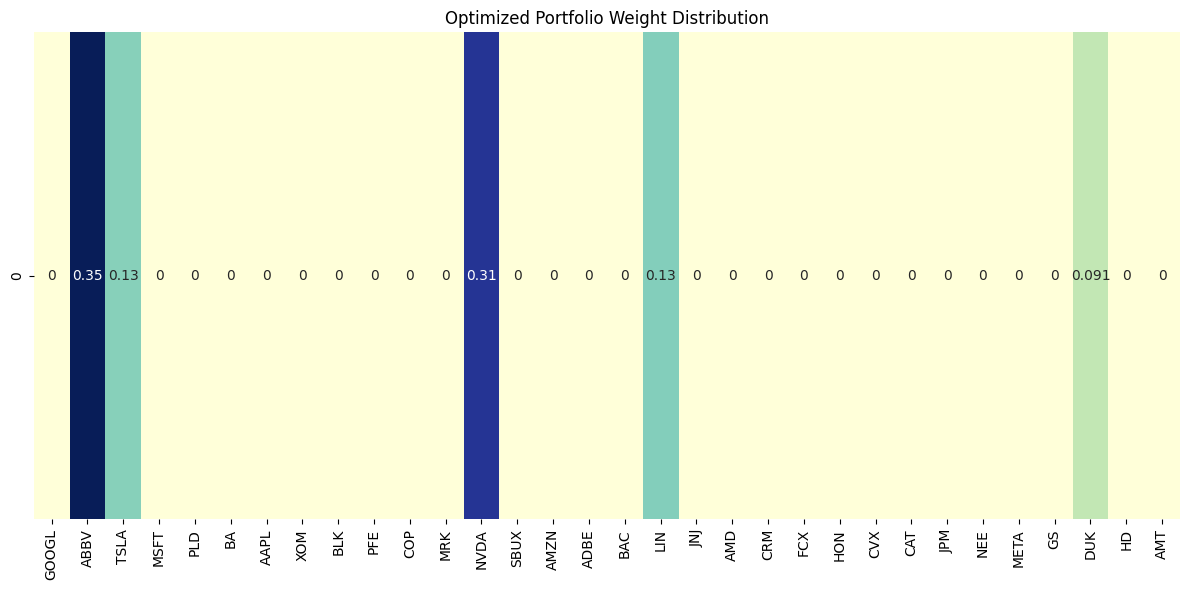

In [33]:
# ========== Weight Heatmap ==========
plt.figure(figsize=(12, 6))
sns.heatmap(pd.DataFrame([cleaned_weights])[price_df.columns], annot=True, cmap="YlGnBu", cbar=False)
plt.title("Optimized Portfolio Weight Distribution")
plt.tight_layout()
plt.show()

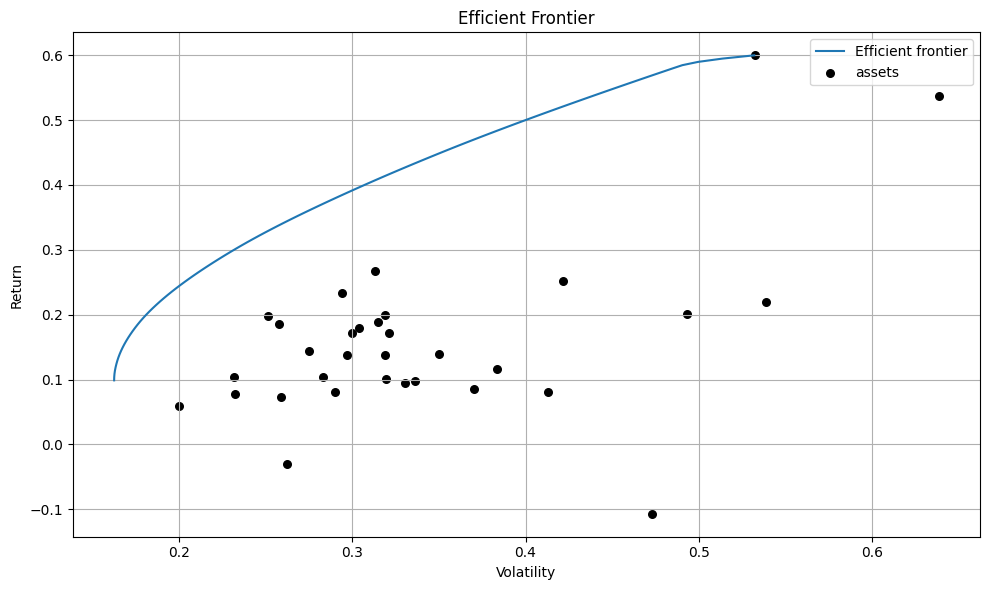

In [34]:
# ========== Efficient Frontier Plot ==========
ef_new = EfficientFrontier(mu, S)
plt.figure(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_new, show_assets=True)
plt.title("Efficient Frontier")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# ========== Risk Parity Portfolio (CVaR) ==========
ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()
print("\nCVaR Portfolio Weights:")
print(pd.Series(cvar_weights).round(4))


CVaR Portfolio Weights:
GOOGL    0.0000
ABBV     0.0747
TSLA     0.0000
MSFT     0.0000
PLD      0.3414
BA       0.0000
AAPL     0.0000
XOM      0.0000
BLK      0.0000
PFE      0.0319
COP      0.0000
MRK      0.1546
NVDA     0.0000
SBUX     0.0000
AMZN     0.0000
ADBE     0.0000
BAC      0.0000
LIN      0.0000
JNJ      0.2625
AMD      0.0000
CRM      0.0000
FCX      0.1349
HON      0.0000
CVX      0.0000
CAT      0.0000
JPM      0.0000
NEE      0.0000
META     0.0000
GS       0.0000
DUK      0.0000
HD       0.0000
AMT      0.0000
dtype: float64


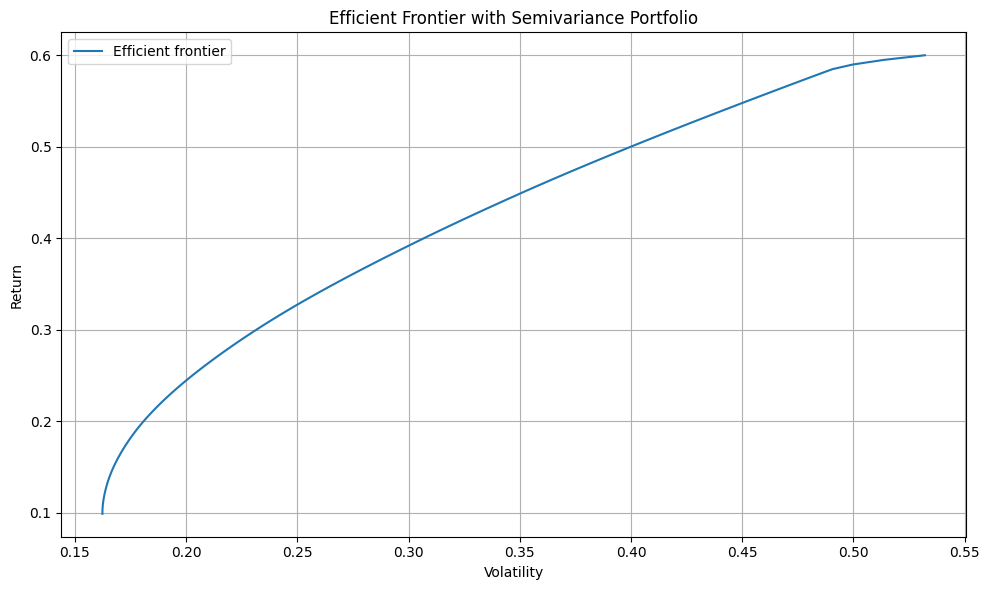

In [36]:
# ========== Semivariance Efficient Frontier ==========
ef_semi = EfficientSemivariance(mu, S)
ef_semi.min_semivariance()
semi_weights = ef_semi.clean_weights()

plt.figure(figsize=(10, 6))
plotting.plot_efficient_frontier(EfficientFrontier(mu, S), show_assets=False)
plt.title("Efficient Frontier with Semivariance Portfolio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# ========== Rolling Optimization (Backtesting Simulation) ==========
rolling_window = 252
rolling_returns = []
for i in range(rolling_window, len(price_df), 21):
    window_df = price_df.iloc[i-rolling_window:i]
    mu_rolling = expected_returns.mean_historical_return(window_df)
    S_rolling = risk_models.CovarianceShrinkage(window_df).ledoit_wolf()
    ef_roll = EfficientFrontier(mu_rolling, S_rolling)
    w = ef_roll.max_sharpe()
    portfolio_return = sum(w[ticker] * mu_rolling[ticker] for ticker in w)
    rolling_returns.append(portfolio_return)


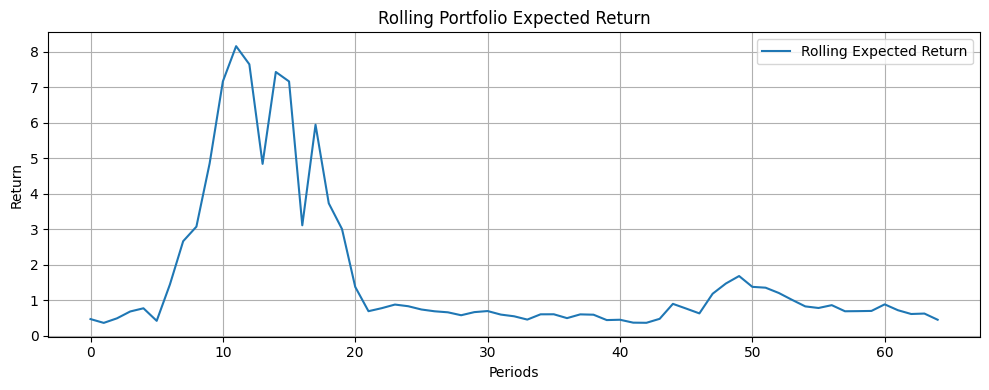

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(rolling_returns, label="Rolling Expected Return")
plt.title("Rolling Portfolio Expected Return")
plt.xlabel("Periods")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# ========== Stress Testing (Market Shock Simulation) ==========
shock_factor = 0.8  # 20% drop
shocked_prices = latest_prices * shock_factor
shocked_value = sum(shocked_prices[ticker] * shares for ticker, shares in allocation.items())
print(f"\nPortfolio Value after 20% Market Shock: ${shocked_value:.2f}")


Portfolio Value after 20% Market Shock: $7969.82


In [43]:
# ========== Black-Litterman Model Integration ==========
# Basic absolute view: "AAPL will outperform GOOGL by 2%"
viewdict = {"AAPL": 0.02, "GOOGL": -0.02}
bl = BlackLittermanModel(S, pi=mu, absolute_views=viewdict)
mu_bl = bl.bl_returns()
ef_bl = EfficientFrontier(mu_bl, S)
bl_weights = ef_bl.max_sharpe()
print("\nBlack-Litterman Optimized Portfolio:")
print(pd.Series(bl_weights).round(4))


Black-Litterman Optimized Portfolio:
GOOGL    0.0000
ABBV     0.4355
TSLA     0.1295
MSFT     0.0000
PLD      0.0000
BA       0.0000
AAPL     0.0000
XOM      0.0000
BLK      0.0000
PFE      0.0000
COP      0.0000
MRK      0.0000
NVDA     0.3145
SBUX     0.0000
AMZN     0.0000
ADBE     0.0000
BAC      0.0000
LIN      0.0602
JNJ      0.0000
AMD      0.0000
CRM      0.0000
FCX      0.0000
HON      0.0000
CVX      0.0000
CAT      0.0000
JPM      0.0000
NEE      0.0000
META     0.0000
GS       0.0000
DUK      0.0603
HD       0.0000
AMT      0.0000
dtype: float64
